# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime
from datetime import timedelta

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland',
                     'United_Kingdom']

## Load country Information
#### Load

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/'
eu_countries = pd.read_csv(url,
                     usecols=['dateRep', 'countriesAndTerritories', 'cases'],
                     parse_dates=['dateRep'],dayfirst=True,
                     index_col=['countriesAndTerritories', 'dateRep']).sort_index()

In [4]:
eu_countries.index.rename(names=['country', 'date'], inplace=True)

In [5]:
targets = eu_countries.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
countries = eu_countries[targets]

## Fix data issues

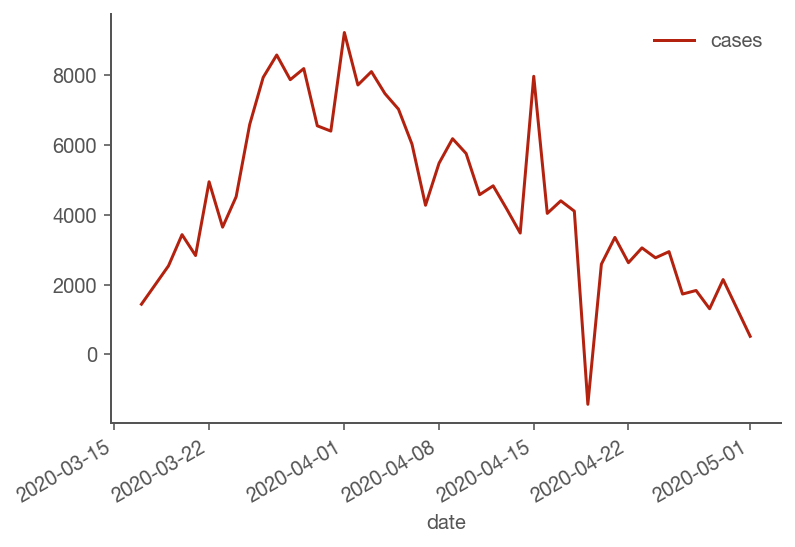

In [6]:
countries.loc['Spain'][-45:].plot()

In [7]:
# make sure Spain still has the broken data
assert countries.loc['Spain'].at['2020-04-15', 'cases'] == 7968
assert countries.loc['Spain'].at['2020-04-19', 'cases'] == -1430

In [8]:
countries.loc['Spain'].at['2020-04-15', 'cases'] = 4021 # was 7968
countries.loc['Spain'].at['2020-04-19', 'cases'] = 3610 # was -1430

In [9]:
# possible number of cases added by the correction
-7968+4021-(-1430)+3610

1093

In [10]:
spain_daterange = pd.date_range('2020-04-17', '2020-04-21')
int(countries.loc['Spain'].loc[spain_daterange.drop(pd.to_datetime('2020-04-19'))].mean())
# countries.loc['Spain'].loc[spain_daterange]

3610

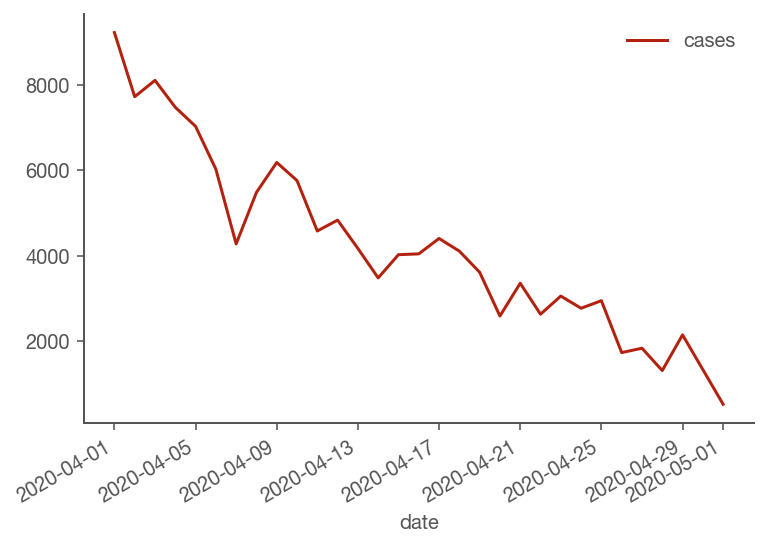

In [11]:
countries.loc['Spain'][-30:].plot()

#### Integrity Check

In [12]:
# Make sure that all the countries have current data
# today = datetime.combine(date.today(), datetime.min.time())
yesterday = datetime.combine(date.today() - timedelta(1), datetime.min.time())
last_updated = countries.reset_index('date').groupby('country')['date'].max()
is_current = last_updated < yesterday

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all countries have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for country, grp in countries.groupby('country'):
    new_cases = grp.cases.dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {country} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that countries have added cases
idx = pd.IndexSlice
assert not countries.loc[idx[:, '2020-04-22':'2020-04-23'], 'cases'].groupby('country').diff().dropna().eq(0).any()

country    date      
Lithuania  2020-04-29   -105
Name: cases, dtype: int64

In [13]:
countries.loc['Germany']

,cases
date,
2019-12-31,0
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
...,...
2020-04-27,1018
2020-04-28,1144
2020-04-29,1304


## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [14]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Done downloading.


#### Parse & Clean Patient Info

In [15]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

In [16]:
patients

,Onset,Confirmed
53,2020-02-08,2020-02-14
55,2020-02-01,2020-02-13
335,2020-01-30,2020-02-14
365,2020-02-14,2020-02-16
446,2020-02-11,2020-02-15
...,...,...
234603,2020-01-16,2020-01-20
234933,2020-02-28,2020-03-10
236344,2020-03-06,2020-03-11
236355,2020-03-05,2020-03-11


#### Show Relationship between Onset of Symptoms and Confirmation

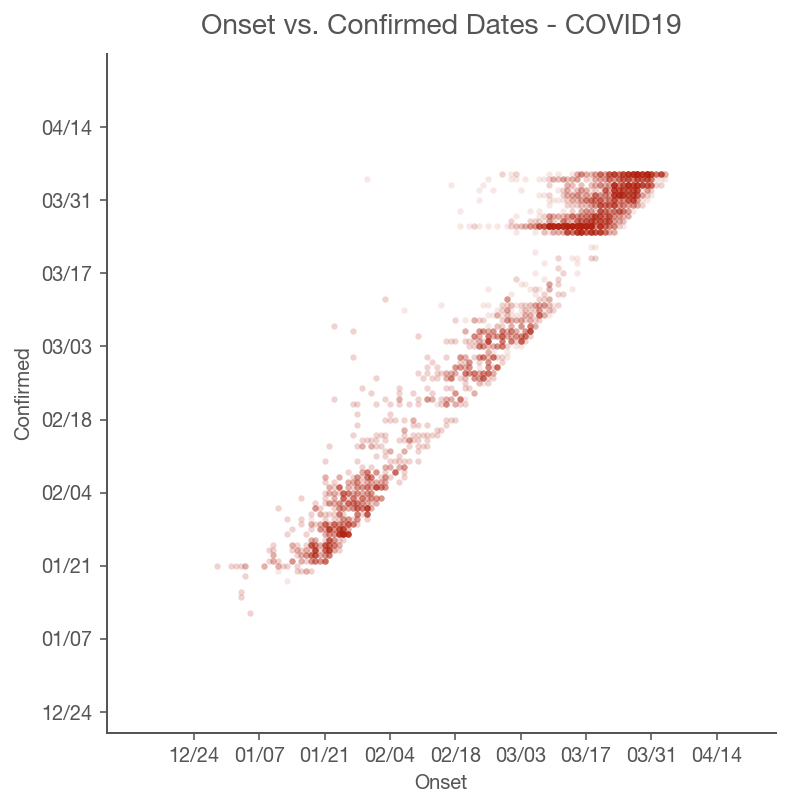

In [17]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

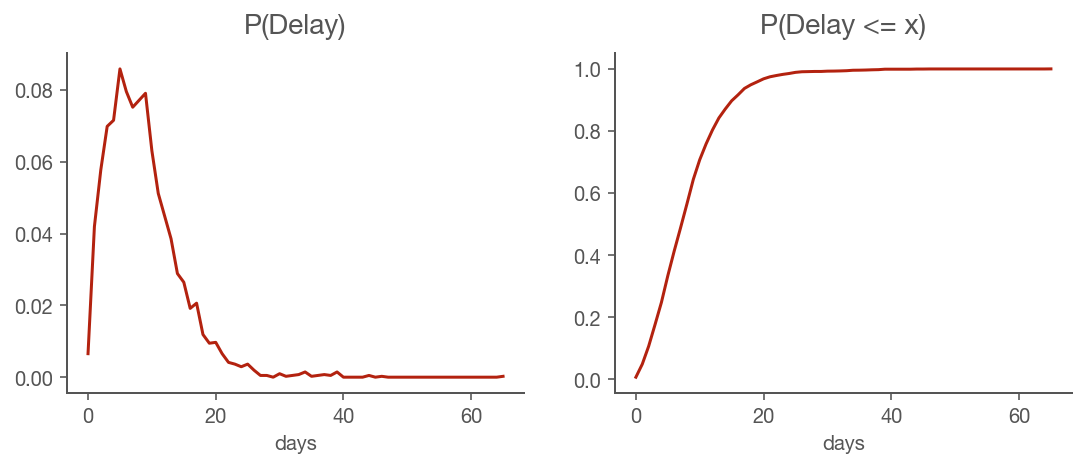

In [18]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [19]:
pdelayDF = pd.DataFrame(p_delay, columns=['pdelay'])
pdelayDF.index.name = 'index'
pdelayDF

,pdelay
index,
0,0.006547
1,0.041950
2,0.057711
3,0.069835
4,0.071532
...,...
61,0.000000
62,0.000000
63,0.000000


In [20]:
pdelayDF.to_csv('data/pdelay.csv')

## A Single Country

#### Select country Data

In [70]:
country = 'Spain'
confirmed = countries.xs(country).cases
confirmed.tail()

date
2020-04-26    1729
2020-04-27    1831
2020-04-28    1308
2020-04-29    2144
2020-05-01     518
Name: cases, dtype: int64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [71]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr, name='Onset')
    return onset

In [72]:
onset = confirmed_to_onset(confirmed, p_delay)

In [73]:
dfs = []
# variable name country_loop to not override country variable defined earlier
for country_loop in COUNTRIES_INCLUDED:
    dataCases = countries.xs(country_loop).cases
    dataOnset = confirmed_to_onset(dataCases, p_delay)
    df = pd.DataFrame(dataOnset)
    df['country'] = country_loop
    df['date'] = df.index
    df.set_index(['country','date'],inplace=True)
    dfs.append(df)
    
finalDF = pd.concat(dfs)
print(finalDF)

                                 Onset
country        date                   
Austria        2019-10-27     0.000000
               2019-10-28     0.000000
               2019-10-29     0.000000
               2019-10-30     0.000000
               2019-10-31     0.000000
...                                ...
United_Kingdom 2020-04-27  1156.725024
               2020-04-28   852.316925
               2020-04-29   545.260912
               2020-04-30   279.725509
               2020-05-01    39.491756

[5185 rows x 1 columns]


In [74]:
finalDF.to_csv('data/onset.csv')

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [75]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

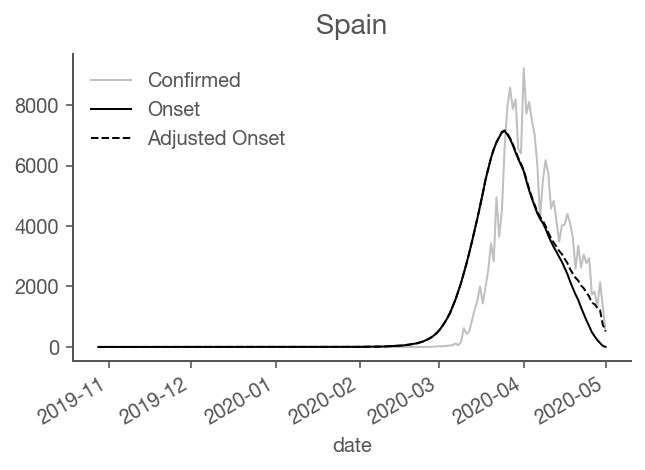

In [76]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=country,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [28]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Laplace('theta_raw_steps', mu=0, b=step_size, shape=len(self.onset)-2)
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [92]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, country):
    confirmed = country.cases
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [93]:
quick_countries = ['Spain']

In [94]:
models = {}

In [95]:
for country, grp in countries.groupby('country'):
    
    # TODO: fixup the data or automate skipping of countries with broken data
    if country == 'Lithuania':
        continue
    
#     if not country in quick_countries:
#         continue
    
    print(country)
    
    if country in models:
        print(f'Skipping {country}, already in cache')
        continue
    
    models[country] = create_and_run_model(country, grp.droplevel(0))

Austria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:46<00:00, 23.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Belgium


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:35<00:00, 41.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Bulgaria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:02<00:00, 21.95it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Croatia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:02<00:00, 21.95it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Cyprus


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:05<00:00, 31.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Czechia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:50<00:00, 36.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Denmark


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:41<00:00, 39.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Estonia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:30<00:00, 19.00it/s]
The acceptance probability does not match the target. It is 0.9941729799283521, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:31<00:00, 18.90it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


France


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:23<00:00, 48.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Germany


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:25<00:00, 46.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Greece


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:23<00:00, 27.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Hungary


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:15<00:00, 29.60it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Ireland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:36<00:00, 41.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Italy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:31<00:00, 43.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Latvia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:21<00:00, 28.20it/s] 
The acceptance probability does not match the target. It is 0.8966775156538219, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Luxembourg


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:02<00:00, 32.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Malta


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:23<00:00, 27.92it/s] 
The acceptance probability does not match the target. It is 0.8161549649128403, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Netherlands


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:38<00:00, 40.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Norway


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:54<00:00, 34.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Poland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:53<00:00, 35.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Portugal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:35<00:00, 41.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Romania


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:55<00:00, 34.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Russia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:37<00:00, 41.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Slovakia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:11<00:00, 30.38it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Slovenia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:27<00:00, 27.19it/s] 
The acceptance probability does not match the target. It is 0.8947795801077891, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Spain


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:13<00:00, 54.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sweden


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:00<00:00, 33.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Switzerland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:30<00:00, 43.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


United_Kingdom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:24<00:00, 47.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [96]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging countries:')
display(divergences[has_divergences])

# Rerun countries with divergences
for country, n_divergences in divergences[has_divergences].items():
    models[country].run()

Diverging countries:


Series([], dtype: int64)

## Compile Results

In [97]:
results = None

for country, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [98]:
results.loc['Spain']

,mean,median,lower_90,upper_90,lower_50,upper_50
date,,,,,,
2020-03-14,1.385264,1.359605,1.141066,1.618692,1.255235,1.454000
2020-03-15,1.372697,1.352219,1.141864,1.604493,1.244867,1.434982
2020-03-16,1.359247,1.338845,1.143364,1.588004,1.221521,1.404783
2020-03-17,1.337354,1.317459,1.114389,1.543118,1.211529,1.379586
2020-03-18,1.311910,1.290462,1.100499,1.493771,1.186611,1.341248
2020-03-19,1.261888,1.242500,1.096778,1.443878,1.145018,1.278052
2020-03-20,1.228422,1.211136,1.083869,1.389487,1.144387,1.259217
2020-03-21,1.179960,1.166636,1.055106,1.305060,1.109281,1.206785
2020-03-22,1.138925,1.130421,1.046442,1.243323,1.068636,1.147620


### Render to CSV
Uncomment if you'd like

In [99]:
results.to_csv('data/rt_mcmc.csv')

### Render Charts

In [100]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.0, 2)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

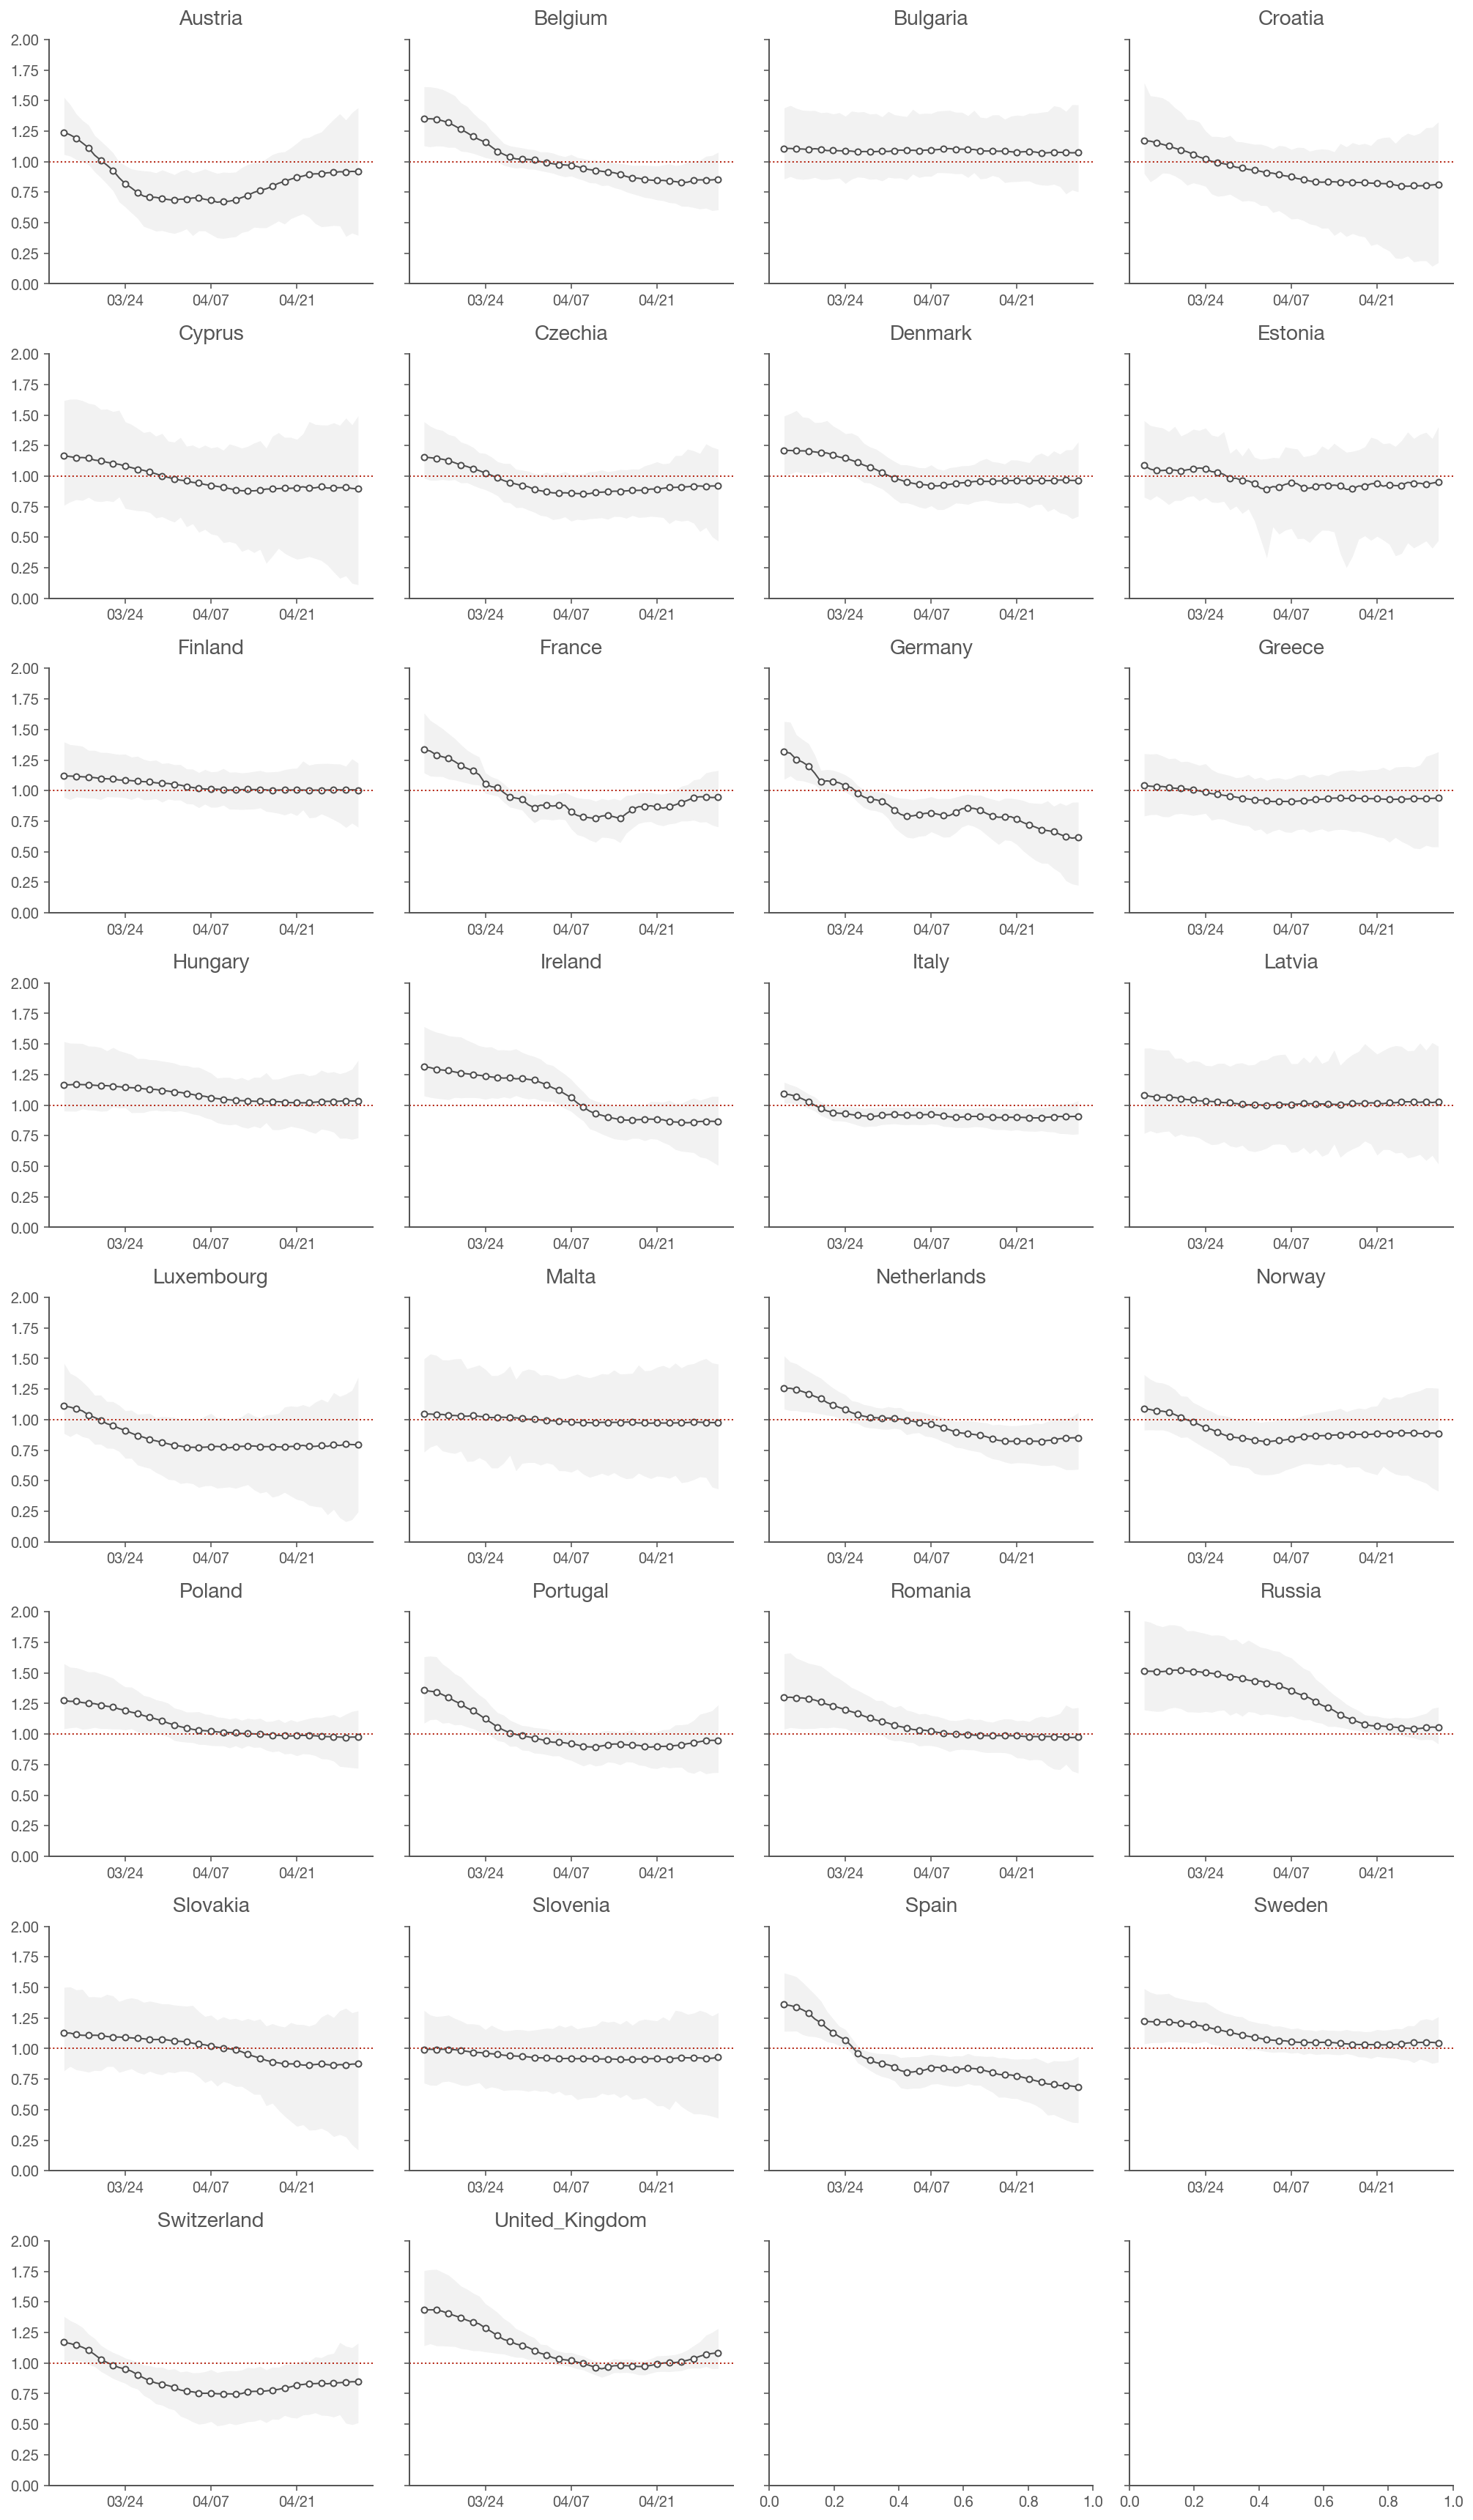

In [101]:
# Laplace walk
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (country, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(country, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
# Gaussain walk
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (country, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(country, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-countries/master/countries.csv'
# abbrev = pd.read_csv(url, index_col=['country'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_country')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# country = 'VT'
# ax = jhu.xs(country).diff().plot(label='JHU', color='k', legend=True, title=country)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# countries.xs(country).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [ ]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-countries/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[country]
    
#     plot_rt(country, result.droplevel(0), ax)
#     plot_rt(country, epf_grp.droplevel(0), ax, c=(1,0,0,1))